### 環境変数(ERG_DATA_DIRもしくはSPEDAS_DATA_DIR)をpyspedasをimportする前に変更することで、データのダウンロード先を変更可能

In [1]:
import os
os.environ["SPEDAS_DATA_DIR"] = "/mnt/j/observation_data/"

## Artemyev先生の見つけたイベント: 2022/09/01

In [ ]:
import pyspedas as psp
import matplotlib as mpl
import pytplot as pt

pt.del_data('*')
mpl.rcdefaults()

time_range = ['20220901/01:00', '20220901/02:00']
psp.erg.mgf(trange=time_range, level='l2', datatype='64hz', coord='sm')
psp.erg.pwe_efd(trange=time_range, level='l2', datatype='spec')
psp.erg.lepe(trange=time_range, level='l2', datatype='omniflux')
psp.erg.orb(trange=time_range, level='l2', datatype='def')

In [ ]:
#pt.tplot_names()
pt.timespan('2022-09-01/01:30:00',30,keyword='minute')
pt.options('erg_lepe_l2_omniflux_FEDO', 'zrange', [1E2, 1E4])
pt.tplot(['erg_lepe_l2_omniflux_FEDO'])

03-Jul-25 14:46:47: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2022/09/
03-Jul-25 14:46:56: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090122_v04.05.cdf
03-Jul-25 14:46:56: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090123_v04.05.cdf
03-Jul-25 14:46:57: Downloading https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090200_v04.05.cdf to /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090200_v04.05.cdf
03-Jul-25 14:46:58: Download complete: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090200_v04.05.cdf


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************


03-Jul-25 14:49:20: /usr/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=21232) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



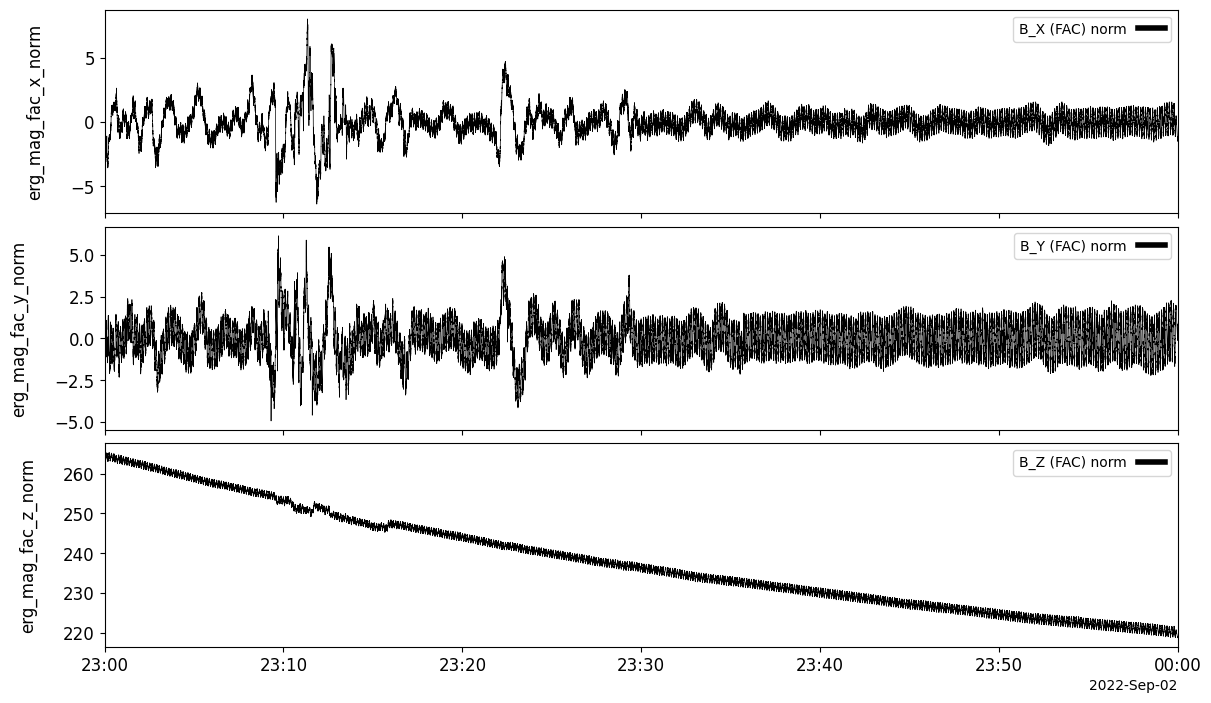

In [5]:
# --- 必要ライブラリ -------------------------------------------------------
import pyspedas as psp
from ergpyspedas.erg import mgf
import pytplot as pt
import numpy as np
import xarray as xr
from multiprocessing import Pool
import os
import pandas as pd

# --- 0. 既存 tplot 変数を全削除 -------------------------------------------
pt.del_data('*')
# --- 1. ERG/MGF データ取得 ----------------------------------------------
time_range = ['20220901/22:50:00', '20220902/00:10:00']
pt.timespan('2022-09-01/23:00:00',1,keyword='hour')
mgf(time_range, level='l2', datatype='64hz', coord='dsi')
mag_raw = pt.data_quants['erg_mgf_l2_mag_64hz_dsi']     # dim=('time','v_dim')

# x, y, z 成分を個別に取り出す（tplot 変数はタプル形式なので注意）
psp.split_vec('erg_mgf_l2_mag_64hz_dsi')
mag_tplot_x = pt.get_data('erg_mgf_l2_mag_64hz_dsi_x')  # (times, values)
mag_tplot_y = pt.get_data('erg_mgf_l2_mag_64hz_dsi_y')
mag_tplot_z = pt.get_data('erg_mgf_l2_mag_64hz_dsi_z')

# --- 2. 移動平均（100 s） -------------------------------------------------
window_sec = 100
# サンプリング周期 [s] を推定（dt ≃ 1/64 s）
sample_period_sec = (
    np.diff(mag_raw['time'].values.astype('datetime64[ns]'))
    .astype(float).mean() * 1e-9
)
window_points = int(window_sec / sample_period_sec)

mag_smoothed = mag_raw.rolling(
    time=window_points, center=True
).mean('time')                                          # 同じ dims

# --- 3. FAC 基底への射影を計算 -------------------------------------------
def fac_projection(
        b_avg_vec: xr.DataArray,
        bx_val: float,
        by_val: float,
        bz_val: float
    ):
    """
    b_avg_vec : 300 s 移動平均磁場（ベクトル, shape=(3,))
    bx_val, by_val, bz_val : 1 サンプルの各成分
    戻り値 :
        fac_components      : 射影後のベクトル (3,)
        fac_scalar_norms    : 各成分のスカラー射影量 (3,)
        fac_unit_vectors    : FAC 基底の単位ベクトル (3x3)
    """
    # 元座標系ベクトル
    original_vec = np.array([bx_val, by_val, bz_val])

    # FAC 基底を構成 -----------------------------------
    z0_global = np.array([0, 0, 1])             # 地球 Z 軸
    e2_fac = np.cross(b_avg_vec, z0_global)      # FAC y
    e1_fac = np.cross(e2_fac, b_avg_vec)         # FAC x
    e3_fac = b_avg_vec                           # FAC z

    # 単位ベクトル
    e1_hat = e1_fac / np.linalg.norm(e1_fac)
    e2_hat = e2_fac / np.linalg.norm(e2_fac)
    e3_hat = e3_fac / np.linalg.norm(e3_fac)

    # スカラー射影
    comp_e1 = np.dot(e1_hat, original_vec)
    comp_e2 = np.dot(e2_hat, original_vec)
    comp_e3 = np.dot(e3_hat, original_vec)

    # ベクトル射影
    vec_e1 = comp_e1 * e1_hat
    vec_e2 = comp_e2 * e2_hat
    vec_e3 = comp_e3 * e3_hat

    fac_components   = np.array([vec_e1, vec_e2, vec_e3])
    fac_scalar_norms = np.array([comp_e1, comp_e2, comp_e3])
    fac_unit_vectors = np.array([e1_hat, e2_hat, e3_hat])

    return fac_components, fac_scalar_norms, fac_unit_vectors

# マルチプロセッシング準備 ---------------------------------------------
n_cpu = os.cpu_count()
bx_values, bx_times = mag_tplot_x.y, mag_tplot_x.times
by_values            = mag_tplot_y.y
bz_values            = mag_tplot_z.y

# 出力用配列
n_samples = len(bx_times)
fac_vecs_x = np.zeros((n_samples, 3))
fac_vecs_y = np.zeros((n_samples, 3))
fac_vecs_z = np.zeros((n_samples, 3))
fac_norms  = np.zeros((n_samples, 3))             # (comp_x, comp_y, comp_z)
fac_e_hat  = np.zeros((n_samples, 3, 3))          # 3 unit vectors / sample

if __name__ == '__main__':
    with Pool(processes=n_cpu) as pool:
        iterator = zip(
            mag_smoothed.values,                 # 平均ベクトル
            bx_values, by_values, bz_values
        )
        results = pool.starmap(fac_projection, iterator)

    for idx, (vecs, norms, e_hat) in enumerate(results):
        fac_vecs_x[idx] = vecs[0]
        fac_vecs_y[idx] = vecs[1]
        fac_vecs_z[idx] = vecs[2]
        fac_norms[idx]  = norms
        fac_e_hat[idx]  = e_hat

# --- 4. tplot 変数に登録 --------------------------------------------------
# 便利用ラベル
component_tags = ['x', 'y', 'z']
scalar_tags    = ['x', 'y', 'z', 'norm']
colors         = ['red', 'green', 'blue', 'black']

for i_comp, comp in enumerate(component_tags):
    # 各ベクトル成分
    comp_fac_list = [
        fac_vecs_x[:, i_comp],
        fac_vecs_y[:, i_comp],
        fac_vecs_z[:, i_comp],
        fac_norms[:, i_comp],
    ]
    for j, tag in enumerate(scalar_tags):
        varname = f'erg_mag_fac_{comp}_{tag}'
        pt.store_data(varname,
                      data={'x': bx_times, 'y': comp_fac_list[j]})
        pt.options(varname, 'legend_names',
                   f'B_{comp.upper()} (FAC) {tag}')
        pt.options(varname, 'color', colors[j])

    # 3 成分＋normをまとめたグループ変数
    pt.store_data(f'erg_mag_fac_{comp}',
                  data=[f'erg_mag_fac_{comp}_x',
                        f'erg_mag_fac_{comp}_y',
                        f'erg_mag_fac_{comp}_z',
                        f'erg_mag_fac_{comp}_norm'])
    pt.options(f'erg_mag_fac_{comp}',
               'ytitle', f'B_{comp} (FAC)\n[nT]')

# --- 5. プロット ---------------------------------------------------------

pt.tplot(['erg_mag_fac_x_norm',
          'erg_mag_fac_y_norm',
          'erg_mag_fac_z_norm'])

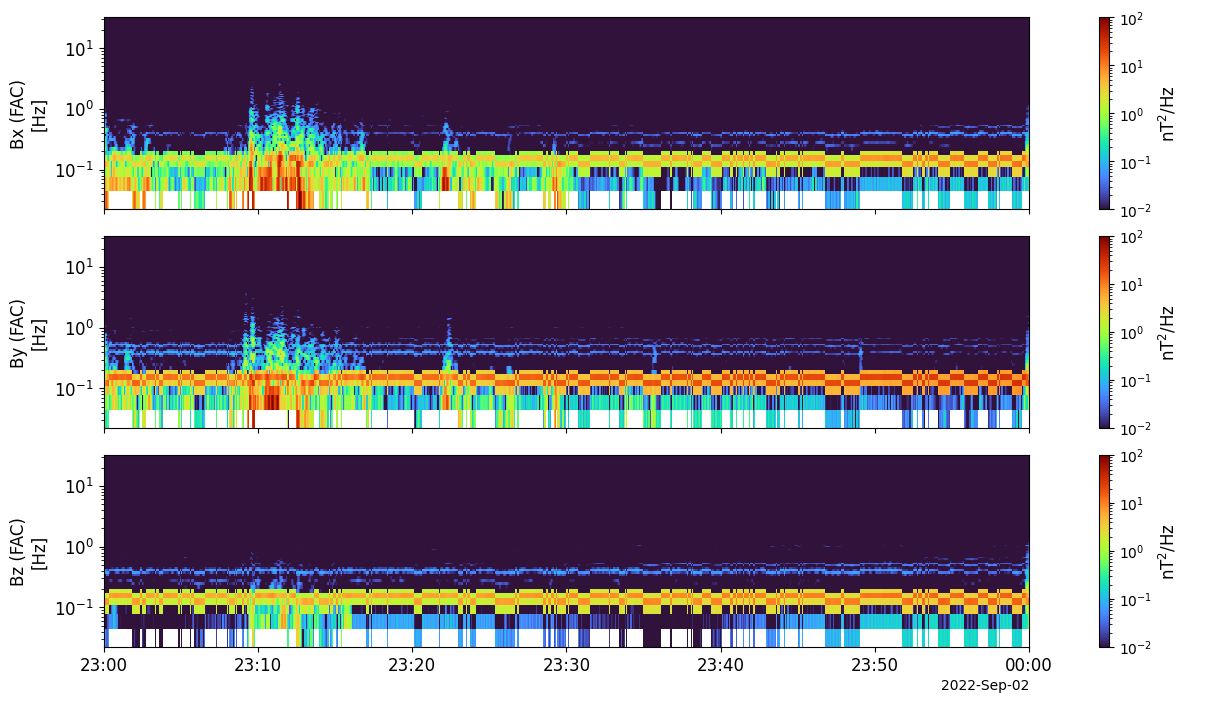

In [6]:
import pytplot as pt

# --- 6. FFT（パワースペクトル密度） -----------------------------------
# FFT 窓長 nfft = 1024 → 1024/64 ≈ 16 s
# overlap = 50%（デフォルト）／boxcar 平滑なし
nbox = 1024 * 2
nshift = nbox // 8

for comp in ['x', 'y', 'z']:
    var_in  = f'erg_mag_fac_{comp}_norm'
    psp.tdpwrspc(var_in, nboxpoints=nbox, nshiftpoints=nshift, bin=1)

# --- 7. スペクトルをプロット --------------------------------------------
# カラーマップはデフォルトで log10(power) [nT²/Hz]
pt.options(['erg_mag_fac_x_norm_dpwrspc',
          'erg_mag_fac_y_norm_dpwrspc',
          'erg_mag_fac_z_norm_dpwrspc'], 'ylog', 1)
#pt.options(['erg_mag_fac_x_norm_dpwrspc',
#          'erg_mag_fac_y_norm_dpwrspc',
#          'erg_mag_fac_z_norm_dpwrspc'], 'yrange', [0, 1])
pt.options(['erg_mag_fac_x_norm_dpwrspc',
          'erg_mag_fac_y_norm_dpwrspc',
          'erg_mag_fac_z_norm_dpwrspc'], 'zrange', [1E-2, 1E2])
pt.options(['erg_mag_fac_x_norm_dpwrspc',
          'erg_mag_fac_y_norm_dpwrspc',
          'erg_mag_fac_z_norm_dpwrspc'], 'zrange', [1E-2, 1E2])
pt.options(['erg_mag_fac_x_norm_dpwrspc',
          'erg_mag_fac_y_norm_dpwrspc',
          'erg_mag_fac_z_norm_dpwrspc'], 'colormap', 'turbo')
pt.options('erg_mag_fac_x_norm_dpwrspc', 'ytitle', 'Bx (FAC)')
pt.options('erg_mag_fac_y_norm_dpwrspc', 'ytitle', 'By (FAC)')
pt.options('erg_mag_fac_z_norm_dpwrspc', 'ytitle', 'Bz (FAC)')
pt.options(['erg_mag_fac_x_norm_dpwrspc',
          'erg_mag_fac_y_norm_dpwrspc',
          'erg_mag_fac_z_norm_dpwrspc'], 'ztitle', 'nT^2/Hz')

pt.tplot(['erg_mag_fac_x_norm_dpwrspc',
          'erg_mag_fac_y_norm_dpwrspc',
          'erg_mag_fac_z_norm_dpwrspc'])

03-Jul-25 14:50:43: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/
03-Jul-25 14:50:44: File is current: /mnt/j/observation_data//ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220901_v02_03.cdf
03-Jul-25 14:50:45: Downloading https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220902_v02_03.cdf to /mnt/j/observation_data//ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220902_v02_03.cdf
03-Jul-25 14:50:47: Download complete: /mnt/j/observation_data//ergsc/satellite/erg/pwe/efd/l2/spec/2022/09/erg_pwe_efd_l2_spec_20220902_v02_03.cdf
03-Jul-25 14:50:47: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/lepe/l2/3dflux/2022/09/
03-Jul-25 14:50:48: File is current: /mnt/j/observation_data//ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220901_v04_01.cdf


 
 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Plasma Wave Experiment (PWE) Electric Field Data (EFD) Level 2 spectrum data']

Information about ERG PWE EFD

PI:  ['Yoshiya Kasahara']
Affiliation:  ['Kanazawa University']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of PWE/EFD: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Pwe/Efd

Contact: erg_pwe_info at isee.nagoya-u.ac.jp
**************************************************************************


03-Jul-25 14:50:50: Downloading https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220902_v04_01.cdf to /mnt/j/observation_data//ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220902_v04_01.cdf
03-Jul-25 14:51:02: Download complete: /mnt/j/observation_data//ergsc/satellite/erg/lepe/l2/3dflux/2022/09/erg_lepe_l2_3dflux_20220902_v04_01.cdf
03-Jul-25 14:51:08: Variable FEDU DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
03-Jul-25 14:51:08: Variable Count_Rate DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
03-Jul-25 14:51:08: Variable Count_Rate_BG DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
03-Jul-25 14:51:12: Variable FEDU DEPEND_1 attribute FEDU_Energy has too many dimensions (3). Keeping extra dimensions (for now).
03-Jul-25 14:51:12: Variable Count_Rate DEPEND_1 attribu

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Low-Energy Particle experiments - electron analyzer (LEP-e) Level 2 3D electron flux data']

Information about ERG LEPe

PI:  ['Shiang-Yu Wang']
Affiliation:  ['Academia Sinica, Taiwan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of LEPe L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Lepe

Contact: erg_lepe_info at isee.nagoya-u.ac.jp
**************************************************************************


03-Jul-25 14:52:11: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090122_v04.05.cdf
03-Jul-25 14:52:11: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090123_v04.05.cdf
03-Jul-25 14:52:11: File is current: /mnt/j/observation_data//ergsc/satellite/erg/mgf/l2/64hz/2022/09/erg_mgf_l2_64hz_dsi_2022090200_v04.05.cdf
03-Jul-25 14:52:12: Downloading remote index: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/orb/def/2022/


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Magnetic Field Experiment (MGF) Level 2 64 Hz resolution magnetic field data']

Information about ERG MGF

PI:  ['Ayako Matsuoka']
Affiliation:  ['Data Analysis Center for Geomagnetism and Space Magnetism, Graduate School of Science, Kyoto University, Kitashirakawa-Oiwake Cho, Sakyo-ku Kyoto 606-8502, Japan']

RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en
RoR of MGF L2: https://ergsc.isee.nagoya-u.ac.jp/mw/index.php/ErgSat/Mgf
Contact: erg_mgf_info at isee.nagoya-u.ac.jp
**************************************************************************


03-Jul-25 14:52:12: File is current: /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220901_v05.cdf
03-Jul-25 14:52:13: Downloading https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220902_v05.cdf to /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220902_v05.cdf
03-Jul-25 14:52:13: Download complete: /mnt/j/observation_data//ergsc/satellite/erg/orb/def/2022/erg_orb_l2_20220902_v05.cdf


 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************


03-Jul-25 14:52:17: /home/satanka/Documents/observation_workspace/.venv_pyspedas/lib/python3.12/site-packages/pyspedas/projects/erg/satellite/erg/particle/erg_pgs_make_e_spec.py:30: RuntimeWarning: invalid value encountered in divide
  ave = data_array.sum(axis=1) / data['bins'].sum(axis=1)



0 : erg_pwe_efd_l2_spec_spectra
1 : erg_pwe_efd_l2_spec_quality_flag
2 : erg_lepe_l2_3dflux_FEDU
3 : erg_mgf_l2_epoch_64hz
4 : erg_mgf_l2_date_time_64hz
5 : erg_mgf_l2_mag_64hz_dsi
6 : erg_mgf_l2_dyn_rng_64hz
7 : erg_mgf_l2_quality_64hz
8 : erg_mgf_l2_quality_64hz_gc
9 : erg_mgf_l2_spin_phase_64hz
10 : erg_mgf_l2_ti_64hz
11 : erg_orb_l2_pos_llr
12 : erg_orb_l2_pos_gse
13 : erg_orb_l2_pos_gsm
14 : erg_orb_l2_pos_sm
15 : erg_orb_l2_pos_rmlatmlt
16 : erg_orb_l2_pos_eq
17 : erg_orb_l2_pos_iono_north
18 : erg_orb_l2_pos_iono_south
19 : erg_orb_l2_pos_blocal
20 : erg_orb_l2_pos_blocal_mag
21 : erg_orb_l2_pos_beq
22 : erg_orb_l2_pos_beq_mag
23 : erg_orb_l2_pos_Lm
24 : erg_orb_l2_vel_gse
25 : erg_orb_l2_vel_gsm
26 : erg_orb_l2_vel_sm
27 : erg_orb_l2_spn_num
28 : erg_orb_l2_man_prep_flag
29 : erg_orb_l2_man_on_flag
30 : erg_orb_l2_eclipse_flag
31 : erg_lepe_l2_3dflux_FEDU_energy


03-Jul-25 14:52:21: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
03-Jul-25 14:52:21: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
03-Jul-25 14:52:21: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
03-Jul-25 14:52:21: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
03-Jul-25 14:52:21: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
03-Jul-25 14:52:21: ['gse', 'gsm', 'sm']
03-Jul-25 14:52:21: Running transformation: subgse2gsm
03-Jul-25 14:52:21: Running transformation: subgsm2sm
03-Jul-25 14:52:21: Setting coordinate system for pos_pgs_temp
03-Jul-25 14:52:21: Output variable: pos_pgs_temp
03-Jul-25 14:52:21: ['sm', 'gsm', 'gse', 'gei', 'j2000']
03-Jul-25 14:52:21: Running transformation: subsm2gsm
03-Jul-25 14:52:21: Running transformation: subgsm2gse
03-Jul-25 14:52:21: Running transformation: subgse2gei
03-Jul-25 14:52:21: Running transformation: subgei2j2000
03-Jul-25 14:52:21: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


03-Jul-25 14:52:33: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
03-Jul-25 14:52:33: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
03-Jul-25 14:52:33: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
03-Jul-25 14:52:33: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
03-Jul-25 14:52:33: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
03-Jul-25 14:52:33: ['gse', 'gsm', 'sm']
03-Jul-25 14:52:33: Running transformation: subgse2gsm
03-Jul-25 14:52:33: Running transformation: subgsm2sm
03-Jul-25 14:52:33: Setting coordinate system for pos_pgs_temp
03-Jul-25 14:52:33: Output variable: pos_pgs_temp
03-Jul-25 14:52:33: ['sm', 'gsm', 'gse', 'gei', 'j2000']
03-Jul-25 14:52:33: Running transformation: subsm2gsm
03-Jul-25 14:52:33: Running transformation: subgsm2gse
03-Jul-25 14:52:33: Running transformation: subgse2gei
03-Jul-25 14:52:33: Running transformation: subgei2j2000
03-Jul-25 14:52:33: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


03-Jul-25 14:52:40: erg_mgf_l2_mag_64hz_dsi copied to erg_mgf_l2_mag_64hz_dsi_pgs_temp
03-Jul-25 14:52:40: tinterpol (linear) was applied to: erg_mgf_l2_mag_64hz_dsi_pgs_temp
03-Jul-25 14:52:40: erg_orb_l2_pos_gse copied to erg_orb_l2_pos_gse_pgs_temp
03-Jul-25 14:52:40: tinterpol (linear) was applied to: erg_orb_l2_pos_gse_pgs_temp
03-Jul-25 14:52:40: erg_orb_l2_pos_gse_pgs_temp copied to pos_pgs_temp
03-Jul-25 14:52:40: ['gse', 'gsm', 'sm']
03-Jul-25 14:52:40: Running transformation: subgse2gsm
03-Jul-25 14:52:40: Running transformation: subgsm2sm
03-Jul-25 14:52:40: Setting coordinate system for pos_pgs_temp
03-Jul-25 14:52:40: Output variable: pos_pgs_temp
03-Jul-25 14:52:40: ['sm', 'gsm', 'gse', 'gei', 'j2000']
03-Jul-25 14:52:40: Running transformation: subsm2gsm
03-Jul-25 14:52:40: Running transformation: subgsm2gse
03-Jul-25 14:52:40: Running transformation: subgse2gei
03-Jul-25 14:52:40: Running transformation: subgei2j2000
03-Jul-25 14:52:40: Setting coordinate system for phi

 
**************************************************************************
['Exploration of Energization and Radiation in Geospace (ERG) Level-2 orbit data']

Information about ERG orbit


RoR of ERG project common: https://ergsc.isee.nagoya-u.ac.jp/data_info/rules_of_the_road.shtml.en

Contact: erg-sc-core at isee.nagoya-u.ac.jp
**************************************************************************
J2000 --> DSI


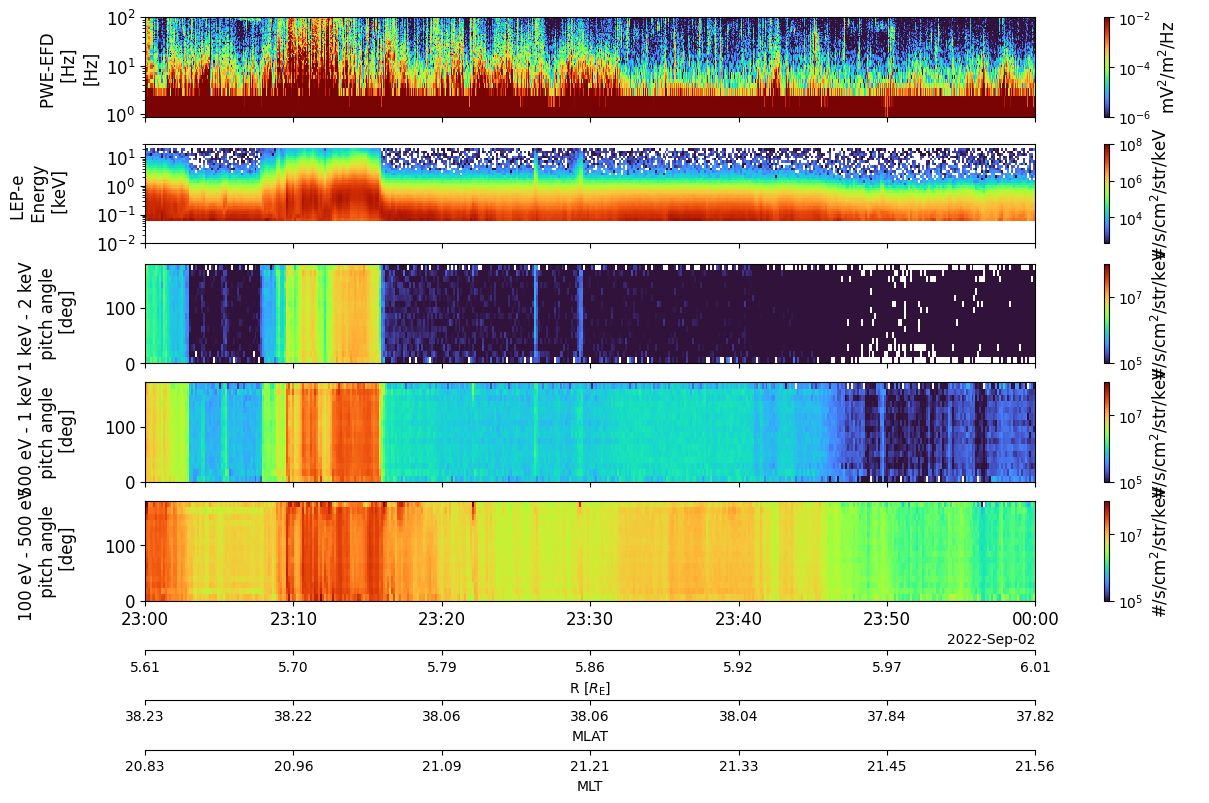

In [7]:
import pytplot as pt
import pyspedas as psp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# データのリセット
pt.del_data('*')
#pt.timespan('2022-09-01/20:00:00',2,keyword='hour')
mpl.rcdefaults()

# データのダウンロード
trange_download = ['20220901/22:50:00', '20220902/00:10:00']
trange = trange_download
psp.erg.pwe_efd(trange_download, level='l2', datatype='spec')
psp.erg.lepe(trange_download, level='l2', datatype='3dflux')
psp.erg.mgf(trange_download, level='l2', datatype='64hz', coord='dsi')
psp.erg.orb(trange_download, level='l2', datatype='def')

# energyデータの作成
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='energy', mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange)
pt.tplot_names()
energy_flux = pt.data_quants['erg_lepe_l2_3dflux_FEDU_energy']

# pitch angleデータの作成
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='pa', energy=[1000, 2000], mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange, suffix='_1-2keV')
energy_flux_pa_10_20 = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_1-2keV']
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='pa', energy=[500, 1000], mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange, suffix='_500-1000eV')
energy_flux_pa_5_10 = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_500-1000eV']
psp.erg.erg_lep_part_products('erg_lepe_l2_3dflux_FEDU', outputs='pa', energy=[100, 500], mag_name='erg_mgf_l2_mag_64hz_dsi', pos_name='erg_orb_l2_pos_gse', trange=trange, suffix='_100-500eV')
energy_flux_pa_1_5 = pt.data_quants['erg_lepe_l2_3dflux_FEDU_pa_100-500eV']

#orbitデータの作成
orb_labels = pt.split_vec('erg_orb_l2_pos_rmlatmlt')

pt.options(orb_labels[0], 'ytitle', r'R [$R_{\mathrm{E}}$]')
pt.options(orb_labels[1], 'ytitle', 'MLAT')
pt.options(orb_labels[2], 'ytitle', 'MLT')


pt.store_data('erg_lepe_l2_3dflux_FEDU_energy_keV', data={'x': energy_flux.time, 'y': energy_flux.data*1E3, 'v': energy_flux.spec_bins*1E-3}, attr_dict=energy_flux.attrs)
pt.store_data('erg_lepe_l2_3dflux_FEDU_pa_1-2keV', data={'x': energy_flux_pa_10_20.time, 'y': energy_flux_pa_10_20.data*1E3, 'v': energy_flux_pa_10_20.spec_bins}, attr_dict=energy_flux_pa_10_20.attrs)
pt.store_data('erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', data={'x': energy_flux_pa_5_10.time, 'y': energy_flux_pa_5_10.data*1E3, 'v': energy_flux_pa_5_10.spec_bins}, attr_dict=energy_flux_pa_5_10.attrs)
pt.store_data('erg_lepe_l2_3dflux_FEDU_pa_100-500eV', data={'x': energy_flux_pa_1_5.time, 'y': energy_flux_pa_1_5.data*1E3, 'v': energy_flux_pa_1_5.spec_bins}, attr_dict=energy_flux_pa_1_5.attrs)
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'ytitle', 'LEP-e \n Energy \n [keV]')
pt.options('erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'ytitle', '1 keV - 2 keV \n pitch angle \n [deg]')
pt.options('erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'ytitle', '500 eV - 1 keV \n pitch angle \n [deg]')
pt.options('erg_lepe_l2_3dflux_FEDU_pa_100-500eV', 'ytitle', '100 eV - 500 eV \n pitch angle \n [deg]')
pt.options('erg_pwe_efd_l2_spec_spectra', 'ytitle', 'PWE-EFD \n [Hz]')
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'yrange', [0.01, 30])
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'ylog', 1)
pt.options('erg_lepe_l2_3dflux_FEDU_energy_keV', 'zrange', [4E2, 1E8])
pt.options(['erg_pwe_efd_l2_spec_spectra', 'erg_lepe_l2_3dflux_FEDU_energy_keV', 'erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'], 'colormap', 'turbo')
pt.options(['erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'], 'zrange', [1E5, 1E8])
pt.options(['erg_lepe_l2_3dflux_FEDU_energy_keV', 'erg_lepe_l2_3dflux_FEDU_pa_1-2keV', 'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV', 'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'], 'ztitle', '#/s/cm^2/str/keV')
pt.options('erg_pwe_efd_l2_spec_spectra', 'ztitle', 'mV^2/m^2/Hz')

bottom_vars = orb_labels

fig = pt.tplot(
    ['erg_pwe_efd_l2_spec_spectra',
    'erg_lepe_l2_3dflux_FEDU_energy_keV',
    'erg_lepe_l2_3dflux_FEDU_pa_1-2keV',
    'erg_lepe_l2_3dflux_FEDU_pa_500-1000eV',
    'erg_lepe_l2_3dflux_FEDU_pa_100-500eV'],
    var_label=bottom_vars
)